## Tutorial
### Project: CMUdict with area function information
The idea of this project is to:
1. Introduce the CMU Pronuncing Dictionary
2. Provide a brief introduction to area functions and why they are useful
3. Provide a dictionary of area functions that serve as archetypal snapshots of the vocal tract during the production of each phone (see `areas.dict`)
4. Provide a small library of utility functions that help a user interface with the provided dictionaries (see `utils.jl`)
5. Give a brief tutorial on how to use said functions (that's what this file--`tutorial.ipynb`--is for)

All code is written in the Julia programming language. Specifically, version 1.9.3 was used for its development. However, the code should work with other versions, including the most recent. The only library used is Plots (v1.40.8) for some visualization, but you can use whatever you want to visualize, so compatibility shouldn't be much of an issue.

### The CMU Pronuncing Dictionary
The CMU Pronouncing Dictionary (CMUdict) is an open-source, machine-readable pronunciation dictionary for North American English, developed by the Speech Group at Carnegie Mellon University. It was initially created for use in speech recognition research and has since become a valuable resource for various speech technology applications.

##### Development
The dictionary was developed to provide a mapping between orthographic (written) and phonetic (spoken) forms of English words. It has been actively maintained and expanded over the years, with contributions from researchers and users. CMUdict contains over 134,000 words and their pronunciations, encoded using the ARPAbet phoneme set, which includes 39 phonemes. Entries have been added to the dictionary from a variety of linguistic sources since its beginning.

##### Format
Each entry in the dictionary is formatted as a plain text line with the word followed by its pronunciation, all separated by spaces. Pronunciations are given in ARPAbet, with stress markers on vowels (0 for no stress, 1 for primary stress, and 2 for secondary stress). If a word has multiple pronunciations, variants are indicated with numbered versions (e.g., WORD(2)).

### Vocal Tract Area Functions
Vocal tract area functions are a one-dimensional representation of the vocal tract, showing the cross-sectional areas along its length from the glottis (voice box) to the lips. These functions map the varying cross-sectional areas of the vocal tract as a function of distance from the glottis. Essentially, this breaks down the vocal tract into a series of "tubelets", each with a specific area. These functions are often derived from imaging techniques like MRI, which provide detailed views of the vocal tract's shape and size. The area functions used in this tutorial come from MRI [(Story et al. 1996)](https://arizona-primo.hosted.exlibrisgroup.com/permalink/f/1h28lag/TN_cdi_proquest_miscellaneous_85544943).

Vocal tract area functions can be used to create accurate acoustic models of speech production. By understanding the shape and size of the vocal tract, researchers can simulate how sound waves travel and resonate within it. For example, they have been used in speech synthesis systems, where these functions help generate natural-sounding speech by accurately modeling the physical properties of the vocal tract.

There are applications of area functions beyond speech synthesis. They can assist in diagnosing and treating speech disorders by revealing abnormalities in the vocal tract's structure. They can also be used for speech science more generally, where they help researchers measure the articulatory configurations that contribute to speech production. Overall, these functions provide a detailed and practical way to study and model the complex process of speech production.

Though area functions are useful, they are only an approximation of a single, static vocal tract configuration. This can be a deceptive simplification of speech processes. By its nature, speech communication is dynamic and continuous. This makes it difficult to describe certain sounds. For example, a plosive consists of a closure of the vocal tract at a specific point, a silent period, and a release of air. Realistically, you can't describe a plosive without giving multiple area functions. To keep things simple, I have limited this dictionary to one area function per sound and only certain sounds are assigned an area function. In the case of vowels, the area function is a pretty good approximation of the sound, as vowels are fairly static. In the case of plosives, the given area function describes the constriction associated with the sound but nothing else.

## Tutorial
We will be using the following two dictionary files for this tutorial. `cmudict.dict` provides a mapping from orthographic words as they appear in texts to a sequence of phones in ARPABET format. I won't go into detail on ARPABET here, but one can think of it as a system of describing speech sounds that only uses machine-readable and easily typed characters. More information can be found at [this Wikipedia page](https://en.wikipedia.org/wiki/ARPABET).

`areas.dict` provides a mapping from ARPABET phones to area functions. Some of the phones do not have a corresponding area function because the articulation that goes into producing them is dynamic and cannot be described in a single "snapshot". I have provided area functions for every phone described in [Story et al. (1996)](https://arizona-primo.hosted.exlibrisgroup.com/permalink/f/1h28lag/TN_cdi_proquest_miscellaneous_85544943).

The `tubelet_length` parameter describes the length of the uniform tubelets that make up our simulated vocal tract. This will be important later when we feed  

In [1]:
using Plots

In [2]:
dict_file = "cmudict.dict"
area_file = "areas.dict"
tubelet_length = 0.396825

0.396825

### Loading the dictionaries
The first step is to load each of the files into a Julia dictionary for easy reference. I have made a structure to contain each part of the process:
```
struct Sequence
    text::String
    phones::Vector{Any}
    areas::Vector{Any}
    frequencies::Vector{Float64}
    responses::Vector{Any}
end
```
This structure format will be returned by a convenience function later in the tutorial.

Then, each of the structure components can be accessed like so: `input_text = area_sequence.text`. Like I said, more on this later.

#### Words-->phones dictionary
Here we map text to corresponding sequences of phones. These phones still contain numbers that denote word-level stress. These stress-markers will be ignored later on. The output of the code cell below shows this dictionary's formatting.

In [3]:
doc = readlines(dict_file)
entries = split.(doc, " ")
phone_dict = Dict()
for i in 1:length(entries)
    phone_dict[entries[i][1]] = entries[i][2:end]
end
phone_dict

Dict{Any, Any} with 135166 entries:
  "coffeen"        => SubString{String}["K", "AH0", "F", "IY1", "N"]
  "rearrangement"  => SubString{String}["R", "IY0", "ER0", "EY1", "N", "JH", "M…
  "tunnell"        => SubString{String}["T", "AH1", "N", "AH0", "L"]
  "daufuskie"      => SubString{String}["D", "OW1", "F", "AH2", "S", "K", "IY0"]
  "dial's"         => SubString{String}["D", "AY1", "AH0", "L", "Z"]
  "inattentive"    => SubString{String}["IH2", "N", "AH0", "T", "EH1", "N", "T"…
  "bladow"         => SubString{String}["B", "L", "AE1", "D", "OW0"]
  "pouncy"         => SubString{String}["P", "UW0", "NG", "K", "IY1"]
  "photosynthesis" => SubString{String}["F", "OW2", "T", "OW0", "S", "IH1", "N"…
  "sleepwalking"   => SubString{String}["S", "L", "IY1", "P", "W", "AO2", "K", …
  "pinheiro"       => SubString{String}["P", "IY0", "N", "HH", "EH1", "R", "OW0…
  "henry"          => SubString{String}["HH", "EH1", "N", "R", "IY0"]
  "aoyama"         => SubString{String}["AW2", "Y", "AA1", "M"

#### Phones-->area functions dictionary
Here we map each phone to its corresponding area function using the other dictionary.

In [4]:
doc = readlines(area_file)
entries = split.(doc, " ")
area_dict = Dict()
for i in 1:length(entries)
    if entries[i][2:end] != ["NA"]
        af = parse.(Float64, entries[i][2:end])
        area_dict[entries[i][1]] = af
    end
end
area_dict

Dict{Any, Any} with 21 entries:
  "T"  => [0.38, 0.5, 0.4, 1.07, 1.38, 1.65, 1.29, 1.01, 0.92, 0.86  …  0.87, 0…
  "P"  => [0.31, 0.39, 0.42, 0.71, 1.28, 1.8, 1.7, 1.43, 1.25, 0.9  …  1.98, 2.…
  "L"  => [0.55, 0.63, 0.75, 1.8, 2.98, 3.56, 3.45, 3.22, 3.2, 2.67  …  6.72, 5…
  "IY" => [0.33, 0.3, 0.36, 0.34, 0.68, 0.5, 2.43, 3.15, 2.66, 2.49  …  0.25, 0…
  "AE" => [0.22, 0.26, 0.26, 0.16, 0.13, 0.21, 0.83, 1.5, 1.35, 0.99  …  3.98, …
  "B"  => [0.31, 0.39, 0.42, 0.71, 1.28, 1.8, 1.7, 1.43, 1.25, 0.9  …  1.98, 2.…
  "IH" => [0.2, 0.17, 0.18, 0.18, 0.1, 1.08, 1.66, 1.64, 1.19, 0.92  …  1.06, 1…
  "ER" => [0.41, 0.38, 0.4, 0.29, 0.13, 0.53, 1.58, 1.56, 1.22, 1.19  …  0.44, …
  "EH" => [0.21, 0.13, 0.16, 0.14, 0.06, 0.78, 1.25, 1.24, 0.99, 0.72  …  1.43,…
  "M"  => [0.57, 0.57, 0.21, 0.58, 2.18, 3.15, 2.96, 2.89, 3.7, 4.21  …  4.79, …
  "AO" => [0.61, 0.28, 0.19, 0.1, 0.07, 0.3, 0.18, 1.13, 1.42, 1.21  …  6.81, 6…
  "N"  => [0.26, 0.24, 0.17, 0.21, 0.15, 0.36, 1.37, 1.66, 1.35, 0.9  …  0.01

#### Text processing and conversion to phones
Here we do a small amount of preprocessing so that we get a sequence of words that match the keys in our pronunciation dictionary. We make sure that all words are lowercase and then use a regular expression to remove punctuation. We use Julia's native broadcasting via dot notation to accomplish this. I find this feature very convenient! As can be seen in the output of the code cell below, we end up with an array of arrays of strings that correspond to ARPABET symbols. I chose to keep the nested array format so that we can still group by word later on if needed.

In [5]:
text = "Happy day."
words = split(text, " ")
words = lowercase.(words)
words = replace.(words, r"[.,;:!?]" => s"")
phones = []
for i in 1:length(words)
    push!(phones, phone_dict[words[i]])
end
phones

2-element Vector{Any}:
 SubString{String}["HH", "AE1", "P", "IY0"]
 SubString{String}["D", "EY1"]

#### Conversion of phone sequences to area functions
Not much to note here. We're just using the dictionary we built earlier to get an area function for each phone if applicable. This is where we ignore the stress markers by removing them with another regular expression.

In [6]:
areas = []
for i in 1:length(phones)
    temp = []
    for j in 1:length(phones[i])
        key = replace(phones[i][j], r"[0-9]" => s"")
        if haskey(area_dict, key)
            push!(temp, area_dict[key])
        else
            push!(temp, nothing)
        end
    end
    push!(areas, temp)
end
areas

2-element Vector{Any}:
 Any[nothing, [0.22, 0.26, 0.26, 0.16, 0.13, 0.21, 0.83, 1.5, 1.35, 0.99  …  3.98, 4.41, 4.56, 4.79, 4.39, 4.42, 4.23, 4.56, 4.31, 3.94], [0.31, 0.39, 0.42, 0.71, 1.28, 1.8, 1.7, 1.43, 1.25, 0.9  …  1.98, 2.21, 2.35, 2.45, 2.37, 2.47, 1.75, 1.09, 0.7, 0.01], [0.33, 0.3, 0.36, 0.34, 0.68, 0.5, 2.43, 3.15, 2.66, 2.49  …  0.25, 0.24, 0.38, 0.28, 0.36, 0.65, 1.58, 2.05, 2.01, 1.58]]
 Any[[0.38, 0.5, 0.4, 1.07, 1.38, 1.65, 1.29, 1.01, 0.92, 0.86  …  0.87, 0.6, 0.1, 0.01, 0.01, 0.13, 0.18, 1.48, 1.6, 1.43], nothing]

#### A bit of application and visualization
We can feed an area function into a transmission line model to get what is called a "frequency response" of the vocal tract. This is beyond the scope of this tutorial, but one can think of it as the relative "importance" of each component frequency to making a specific sound. The peaks you see in the line plotted below are the resonant (important) frequencies, commonly referred to as formants.

The function below uses the transmission line model to get us a frequency response for every available area function. You might notice that we also feed an array of lengths into the model alongside the areas. These numbers specify the length of each tubelet. Uniform tubelets of a given length were used in the study where they measured these area functions, so all we need to do is provide an array of the tubelet length that matches the size of the area array.

You may also be wondering about this bit: `20 .* log10.(abs.(h))`. This is a conversion to decibels!

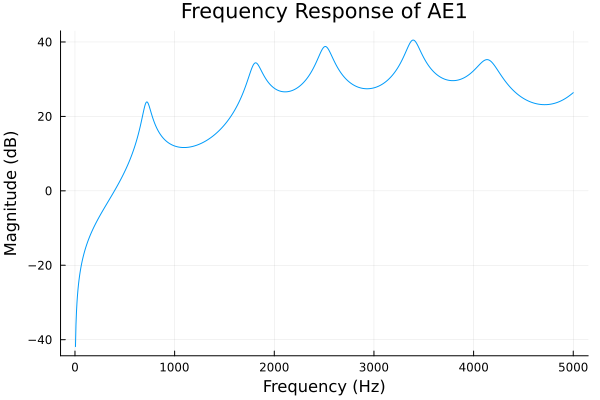

In [7]:
include("./utils.jl")

frequencies = []
responses = []
for i in 1:length(areas)
    temp = []
    for j in 1:length(areas[i])
        if areas[i][j] != nothing
            af = areas[i][j]
            frequencies, h, _, _ = transmission_line_model(af, fill(tubelet_length, length(af)))
            push!(temp, 20 .* log10.(abs.(h)))
        else
            push!(temp, nothing)
        end
    end
    push!(responses, temp)
end
plot(frequencies, responses[1][2], xlabel="Frequency (Hz)", ylabel="Magnitude (dB)", label="", title="Frequency Response of $(phones[1][2])")

##### Convenience functions
Now we've gone through the steps individually, but it sure would be nice if there was a convenience function that took care of all of that behind the scenes! That function is `create_structure()`. The parameters of that function are as follows:
- `text`: The text that you want to convert into area functions
- `dict_file`: The name of the main cmudict file
- `area_file`: The name of the area function dictionary file that I provided
- `tubelet_length`: The length of the uniform tubelets -- just in case you want to play around

Aside from the `text` parameter, these all have defaults set, so you can do a really simple call like this:

In [8]:
seq = create_structure("Hello there, happy day!")
seq

Sequence("Hello there, happy day!", Any[SubString{String}["HH", "AH0", "L", "OW1"], SubString{String}["DH", "EH1", "R"], SubString{String}["HH", "AE1", "P", "IY0"], SubString{String}["D", "EY1"]], Any[Any[nothing, [0.33, 0.28, 0.23, 0.15, 0.17, 0.33, 0.39, 1.02, 1.22, 1.14  …  5.79, 5.51, 5.49, 4.69, 4.5, 3.21, 2.79, 2.11, 1.98, 1.17], [0.55, 0.63, 0.75, 1.8, 2.98, 3.56, 3.45, 3.22, 3.2, 2.67  …  6.72, 5.61, 4.08, 2.73, 0.45, 0.9, 3.92, 4.99, 4.57, 3.7], [0.18, 0.17, 0.23, 0.28, 0.59, 1.46, 1.6, 1.11, 0.82, 1.01  …  4.39, 5.38, 7.25, 7.0, 4.57, 2.75, 1.48, 0.68, 0.39, 0.14]], Any[nothing, [0.21, 0.13, 0.16, 0.14, 0.06, 0.78, 1.25, 1.24, 0.99, 0.72  …  1.43, 1.83, 2.08, 2.59, 2.54, 2.11, 2.34, 2.74, 2.19, 1.6], nothing], Any[nothing, [0.22, 0.26, 0.26, 0.16, 0.13, 0.21, 0.83, 1.5, 1.35, 0.99  …  3.98, 4.41, 4.56, 4.79, 4.39, 4.42, 4.23, 4.56, 4.31, 3.94], [0.31, 0.39, 0.42, 0.71, 1.28, 1.8, 1.7, 1.43, 1.25, 0.9  …  1.98, 2.21, 2.35, 2.45, 2.37, 2.47, 1.75, 1.09, 0.7, 0.01], [0.33, 0.3, 

This returns a Julia Struct. It is a simple, organized way to contain data of a variety of types in one "object". Want the area functions? Just use `structname.areas`. Can't remember what text you entered? It is contained in `structname.text`.

##### Visualization
Finally, I thought it would be illustrative to visualize the area functions. Nothing crazy going on here, but I will note that we aren't plotting area by length here. We use the calculation `sqrt(a / π)` to calculate the radius of the tubelet, rather than the cross-sectional area of the tubelet. The rest of this code is just there so that we can plot this in a sensible way.

This first one is the first vowel in the word "happy".

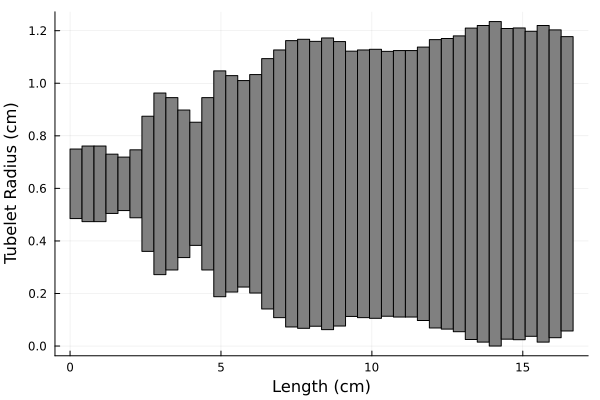

In [9]:
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
a = seq.areas[3][2]
a = @. sqrt(a / π)
l = fill(0.396825, length(a))
p = plot(xlabel="Length (cm)", ylabel="Tubelet Radius (cm)")
x_offset = 0.0
half_max_a = maximum(a) / 2
for i in 1:length(a)
    y_offset = half_max_a - (a[i] / 2)
    plot!(rectangle(l[i], a[i], x_offset, y_offset), label="", color=:gray)
    x_offset += l[i]
end
display(p)

The function below shows the second vowel in "happy". Note the much more open configuration in the figure above. The figure below shows the constriction you make at the roof of your mouth at the narrow section in the graph.

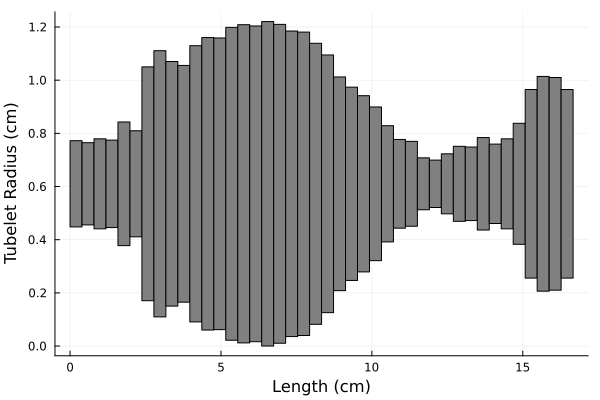

In [10]:
p = plot_vt_radii(seq.areas[3][4])
display(p)

### Conclusion
Thank you for sticking with it! This is only a first attempt at making this sort of thing, and I know that there is a lot more to be done. Below is a list of some things I thought about.

### Future Directions
Here are some things that would need to be done in order to make a more functional/useful system:
- Decide on/document a method for dealing with phones that aren't described well by a single snapshot
- Add more area functions to fill out the dictionary
- Add a synthesizer so that you can go from a frequency response to audio
- Add a function to animate the transitions between area functions